In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
import matplotlib.pyplot as plt
import numpy as np
from epi.models import Parameter, Model
from epi.util import pairplot
from epi.SC_Circuit_4 import SC_acc, SC_sim, unwrap

### 1. Define the V1Circuit model

In [11]:
lb = -5.
ub = 0.

sW = Parameter("sW", 1, lb=lb, ub=ub)
vW = Parameter("vW", 1, lb=lb, ub=ub)
dW = Parameter("dW", 1, lb=lb, ub=ub)
hW = Parameter("hW", 1, lb=lb, ub=ub)

parameters = [sW, vW, dW, hW]

model = Model("SC_Circuit", parameters)

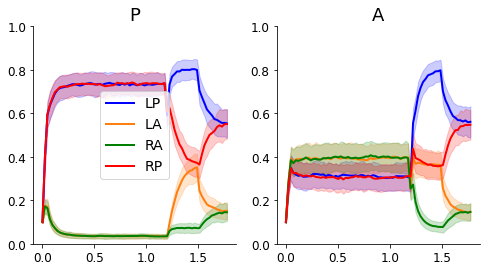

In [12]:
z = np.array([[-1.7, -0.2567, 0.22, -2.43]], dtype=np.float32)

t_cue_delay = 1.2
t_choice = 0.3
t_post_choice = 0.3
t_total = t_cue_delay + t_choice + t_post_choice
dt = 0.024
t = np.arange(0.0, t_total, dt)
T = t.shape[0]

u_t, v_t = SC_sim(*unwrap(-np.ones((1,4), dtype=np.float32)))

neuron_labels = ['LP', 'LA', 'RA', 'RP']
colors = ['b', 'tab:orange', 'g', 'r']
C_titles = ['P', 'A']
for m in range(1):
    fig, axs = plt.subplots(1,2,figsize=(8, 4))
    for c in range(2):
        for i in range(4):
            mean_v = np.mean(v_t[:,m,c,i,:], axis=1)
            std_v = np.std(v_t[:,m,c,i,:], axis=1)
            axs[c].fill_between(t, mean_v - std_v, mean_v + std_v, color=colors[i], alpha=0.2)
            axs[c].plot(t, mean_v, label=neuron_labels[i], c=colors[i])
            axs[c].set_title(C_titles[c])
            axs[c].set_ylim([0,1])
    axs[0].legend()
    plt.show()


### 2. Define eps function using Euler

In [13]:
model.set_eps(SC_acc)

def accept_inds(T_x, means, stds):
    acc = np.array([np.logical_and(means[i] - 2*stds[i] < T_x[:,i], 
                    T_x[:,i] < means[i] + 2*stds[i]) for i in range(len(means))])
    return np.logical_and.reduce(acc, axis=0)
                          

In [14]:
num_keep = 100
M = 1000
zs = []
T_xs = []

p = .75
means = [p, 1-p]
stds = [0.025, 0.025]

num_found = 0
z = None
T_x = None
while (num_found < num_keep):
    _z = np.zeros((M, model.D), dtype=np.float32)
    for j in range(model.D):
        _z[:,j] = np.random.uniform(model.parameters[j].lb, model.parameters[j].ub, (M,))
    _T_x = model.eps(_z).numpy()

    inds = accept_inds(_T_x, means, stds) 
    _z = _z[inds, :]
    _T_x = _T_x[inds, :]
    num_found += _z.shape[0]

    if (z is None):
        z = _z
        T_x = _T_x
    else:
        z = np.concatenate((z, _z), axis=0)
        T_x = np.concatenate((T_x, _T_x), axis=0)
    print('%d/%d\r' % (num_found, num_keep), end='')

    num_found = z.shape[0]

# reduce to num_keep
z = z[:num_keep]
T_x = T_x[:num_keep]

num_plot = 500
fontsize = 20

KeyboardInterrupt: 

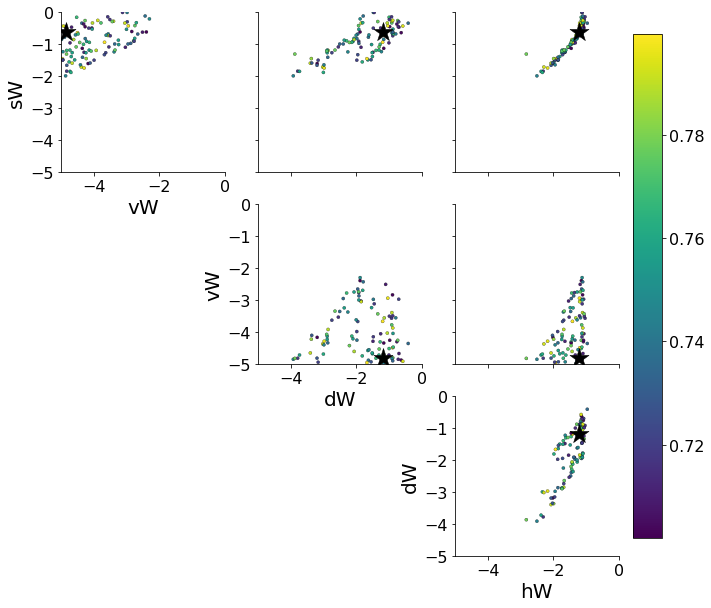

In [14]:
z_labels = [p.name for p in model.parameters]
#z_star = np.mean(z, axis=0)[None,:]
z_star = z[0,:][None,:]

fig = pairplot(z[:num_plot], np.arange(4), z_labels,
               fontsize=fontsize, figsize=(10,10), starred=z_star,
               lb=_lb, ub=_ub, c = T_x[:,0])

z [-1.145549  -4.6404953 -2.4986358 -1.6085186]


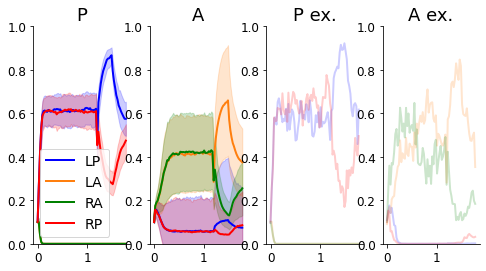

z [-0.81311595 -3.244829   -2.3047101  -1.3620317 ]


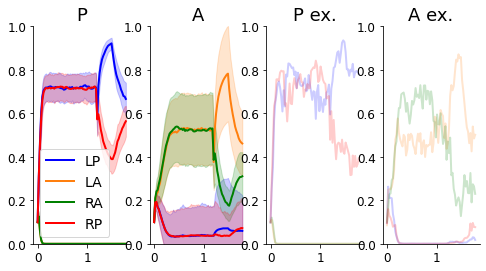

z [-0.450335  -4.0805407 -1.121526  -1.0609871]


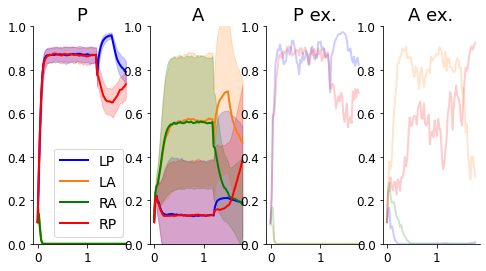

z [-1.0527927 -3.2376986 -2.5242152 -1.4207292]


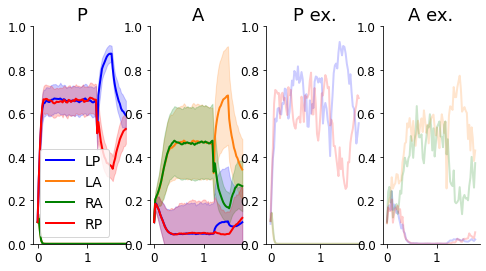

z [-0.23542656 -4.1050506  -0.8809551  -1.1467824 ]


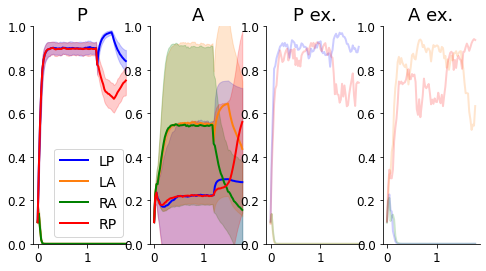

z [-0.15783957 -2.151244   -0.8184036  -1.0493    ]


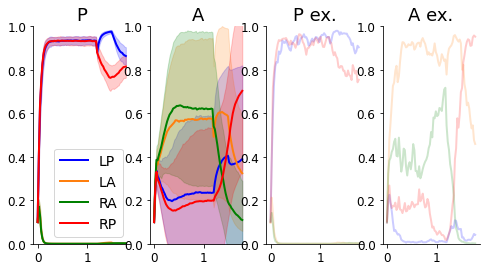

z [-1.5256081 -4.493977  -1.8835301 -2.0068915]


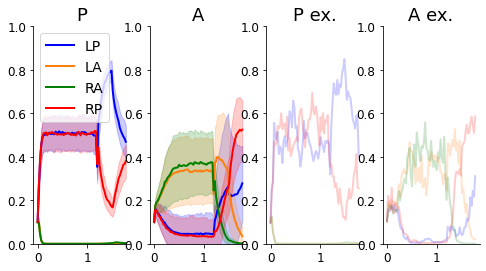

z [-0.0448586 -3.541295  -1.0359792 -1.0792267]


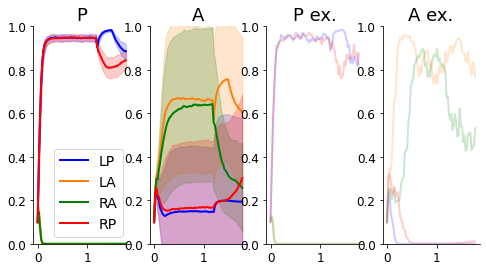

z [-0.02195954 -2.9372938  -0.68220824 -1.0976574 ]


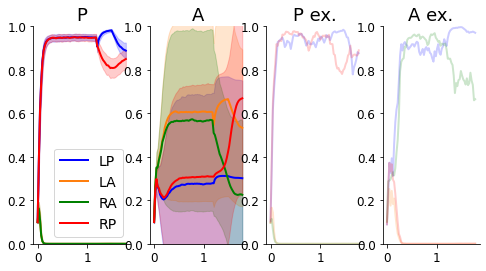

z [-0.91654485 -3.7041411  -2.1257176  -1.3049115 ]


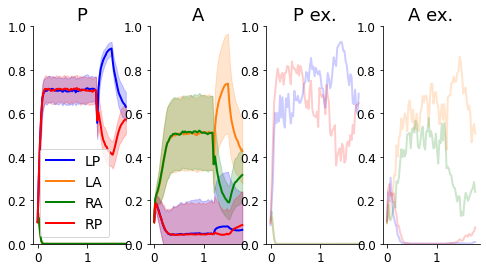

In [16]:
u_t, v_t = SC_sim(*unwrap(z))

neuron_labels = ['LP', 'LA', 'RA', 'RP']
colors = ['b', 'tab:orange', 'g', 'r']
C_titles = ['P', 'A']
for m in range(10):
    fig, axs = plt.subplots(1,4,figsize=(8, 4))
    print('z', z[m])
    for c in range(2):
        for i in range(4):
            mean_v = np.mean(v_t[:,m,c,i,:], axis=1)
            std_v = np.std(v_t[:,m,c,i,:], axis=1)
            axs[c].fill_between(t, mean_v - std_v, mean_v + std_v, color=colors[i], alpha=0.2)
            axs[c].plot(t, mean_v, label=neuron_labels[i], c=colors[i])
            axs[c].set_title(C_titles[c])
            axs[c].set_ylim([0,1])
            axs[c+2].plot(t, v_t[:,m,c,i,0], color=colors[i], alpha=0.2)
            axs[c+2].set_ylim([0,1])
            axs[c+2].set_title(C_titles[c] + ' ex.')
    axs[0].legend()
    plt.show()


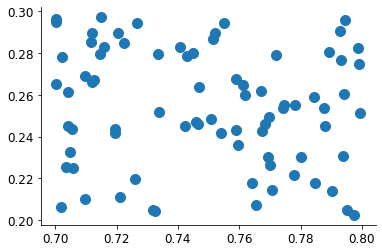

In [17]:
plt.scatter(T_x[:,0], T_x[:,1])

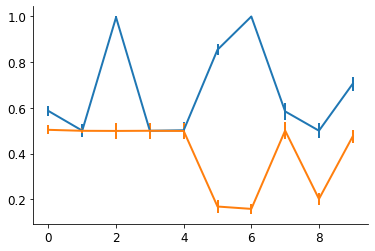

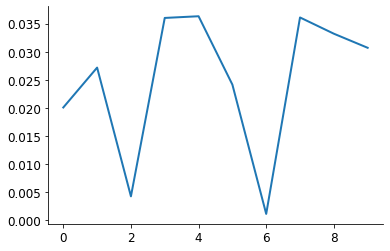

In [19]:
M_rand = 10
z_rand = np.array([np.random.normal(z_star[0,i], 1., (M_rand,)) for i in range(4)], dtype=np.float32).T
T_x_rands = []
N_samp = 250
for i in range(N_samp):
    T_x_rands.append(model.eps(z_rand))
    
T_x_rands = np.stack(T_x_rands, axis=0)
p_mean = np.mean(T_x_rands, axis=0)
p_std = np.std(T_x_rands, axis=0)
plt.figure()
plt.errorbar(np.arange(p_mean.shape[0]), p_mean[:,0], p_std[:,0])
plt.errorbar(np.arange(p_mean.shape[0]), p_mean[:,1], p_std[:,1])
plt.show()

plt.figure()
plt.plot(np.arange(p_mean.shape[0]), p_std[:,0])
plt.show()
